In [200]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import scipy
import scipy.io
from scipy.signal import spectrogram
import os
import soundfile as sf
import librosa
import math
from librosa.feature import melspectrogram
from librosa.display import specshow
import cv2
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report

In [51]:
# # Prepare Spectrogram Dataset
# for data in spect_dataset:
#     prevname = data[4].split('.')[0]
#     filename = '{}-{}-fold{}-{}.png'.format(data[0], data[2], data[3], prevname)
#     spect = melspectrogram(data[1].numpy(), data[2])
#     spect_scaled = 255 * (spect - spect.min()) / (spect.max() - spect.min())
#     plt.imsave('Spectrograms/'+filename, spect, cmap='gray')

In [2]:
# Try with 1D convolution

# Get spect_dataset
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8k.csv')

class_dict = {'siren': 0,
             'jackhammer': 1,
             'air_conditioner': 2,
             'drilling': 3,
             'children_playing': 4,
             'street_music': 5,
             'dog_bark': 6,
             'engine_idling': 7,
             'gun_shot': 8,
             'car_horn': 9}

class SoundDataset(Dataset):
    def __init__(self, metadata):
        self.sample_list = []
        
        for i in range(1,11):
            data_dir = 'fold{}'.format(i)
            if (data_dir[0] == '.'):
                continue
        
            for filename in os.listdir('UrbanSound8k/audio/{}'.format(data_dir)):
                if filename[0] == '.':
                    continue
                data, samplerate = librosa.load('UrbanSound8k/audio/{}/{}'.format(data_dir,filename))
                label = metadata.loc[metadata['slice_file_name'] == filename, 'class'].item()
                if len(data.shape) == 2:
                    data = np.mean(data, axis = 1)
                if len(data) == 88200:
                    self.sample_list.append((class_dict[label], torch.tensor(data),
                                             samplerate, i, filename)) #class label, data, samplerate, fold, filename
                
    
    def __len__(self):
        return len(self.sample_list)
    
    def __getitem__(self, idx):
        return self.sample_list[idx]

In [226]:
# Try with 2D convolution. Import Spectrogram Dataset.

# Get spect_dataset
class SpectDataset(Dataset):
    def __init__(self):
        self.sample_list = []
        
        for filename in os.listdir('Spectrograms'):
            label = filename.split('-')[0]
            image = plt.imread('Spectrograms/'+filename)[:,:,0]
            if int(label) == 8:
                continue
            elif int(label) == 9:
                self.sample_list.append((int(label) - 1, torch.tensor(image), filename)) #class_label, data, filename
            else:
                self.sample_list.append((int(label), torch.tensor(image), filename)) #class_label, data, filename
                
    
    def __len__(self):
        return len(self.sample_list)
    
    def __getitem__(self, idx):
        return self.sample_list[idx]

In [227]:
# Load the data (spectrogram)
spect_dataset = SpectDataset()

In [228]:
# Load the data (audio)
#spect_dataset = SoundDataset(metadata)

In [235]:
# Split into train, val, test data
train_len = int(0.6 * len(spect_dataset))
val_len = len(spect_dataset) - train_len
trainset, valset = random_split(spect_dataset, [train_len, val_len])

val_len = int(0.5 * len(valset))
valset, testset = random_split(valset, [val_len, val_len])

In [236]:
# Create Neural Network Model
class AudioNet(nn.Module):  #1D convolutions
    def __init__(self, num_classes):
        super(AudioNet, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 16, kernel_size=23, stride=5, padding=0) #try making kernels larger, fewer layers, less maxp
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=7, stride=3, padding=0)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.lrelu = nn.LeakyReLU()
        self.max2 = nn.MaxPool1d(kernel_size=3)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=3, padding=0)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.drop = nn.Dropout(p=0.5)
        self.max3 = nn.MaxPool1d(kernel_size=3)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=5, stride=3, padding=0)
        self.batchnorm4 = nn.BatchNorm1d(64)
        self.conv5 = nn.Conv1d(64, 64, kernel_size=7, stride=3, padding=0)
        self.fc1 = nn.Linear(64 * 22, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        #print(x.shape)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.lrelu(x)
        #print(x.shape)
        x = self.max2(x)
        #print(x.shape)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.drop1(x)
        #print(x.shape)
        x = self.max3(x)
        #print(x.shape)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        #print(x.shape)
        x = self.conv5(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        #print(x.shape)
        out = self.fc2(x)
        #print(out.shape)
        return out
    
    
class AudioNetSpect(nn.Module):  #2D convolutions on spectrograms
    def __init__(self, num_classes):
        super(AudioNetSpect, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=0) #try making kernels larger, fewer layers, less maxp
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.drop1 = nn.Dropout(p=0.5)
        self.lrelu1 = nn.LeakyReLU()
        self.max1 = nn.MaxPool2d(kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.drop2 = nn.Dropout(p=0.5)
        self.lrelu2 = nn.LeakyReLU()
        self.max2 = nn.MaxPool2d(kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 13, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.drop1(x)
        x = self.lrelu1(x)
        x = self.max1(x)
        #print(x.shape)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.drop2(x)
        x = self.lrelu2(x)
        #print(x.shape)
        x = self.max2(x)
        #print(x.shape)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        out = self.fc2(x)
        #print(out.shape)
        return out

In [237]:
# Load model
model = AudioNetSpect(num_classes=9)
model.cuda()

AudioNetSpect(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (lrelu1): LeakyReLU(negative_slope=0.01)
  (max1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (lrelu2): LeakyReLU(negative_slope=0.01)
  (max2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6656, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [238]:
# Get loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [263]:
# Create data loaders
val_loader = DataLoader(dataset = valset,
                      batch_size = 32,
                      shuffle = False)

train_loader = DataLoader(dataset = trainset,
                      batch_size = 32,
                      shuffle = True)

test_loader = DataLoader(dataset = testset,
                      batch_size = 32,
                      shuffle = True)

data_loader = DataLoader(dataset = spect_dataset,
                      batch_size = 32,
                      shuffle = True)

In [240]:
# Train the model
best_val_loss = math.inf
num_epochs = 50

for epoch in range(num_epochs):
    tot_train_loss = 0
    tot_train_samples = 0
    
    # Train Loop
    model.train()
    for i, (label, data, filename) in enumerate(train_loader):
        data = data.type(torch.FloatTensor).cuda().unsqueeze(1)
        label = label.long().cuda()
        
        optimizer.zero_grad() # clear gradients
        outputs = model(data) # get outputs
        train_loss = criterion(outputs, label) # get batch loss
        tot_train_loss += train_loss.item() # add batch loss to total loss
        tot_train_samples += data.shape[0] # add number of samples to total number of samples
        train_loss.backward() # get gradients
        optimizer.step() # update parameters
    avg_train_loss = tot_train_loss / len(train_loader)
    
    # Eval Loop
    tot_val_loss = 0
    tot_val_samples = 0
    pred_vec = []
    label_vec = []
    
    model.eval()
    for i, (label, data, filename) in enumerate(val_loader):
        data = data.type(torch.FloatTensor).cuda().unsqueeze(1)
        label = label.long().cuda()
        
        outputs = model(data) # get outputs
        val_loss = criterion(outputs, label) # get batch loss
        tot_val_loss += val_loss.item() # add batch loss to total loss
        tot_val_samples += data.shape[0] # add number of samples to total number of samples
        
        # Predictions
        #_, predicted = torch.max(outputs.data, 1)
        #pred_vec += list(np.array(predicted.cpu()).ravel())
        #label_vec += list(np.array(labels.cpu()).ravel())
    avg_val_loss = tot_val_loss / len(val_loader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'models/audio_net_spect.pt')
        
    # print losses every 5 epochs
    if (epoch + 1) % 5 == 1 or (epoch + 1) == num_epochs:
        print('Epoch {}'.format(epoch + 1))
        print('Training Loss: {}'.format(avg_train_loss))
        print('Val Loss: {} \n'.format(avg_val_loss))

Epoch 1
Training Loss: 1.908411359852129
Val Loss: 2.018740845763165 

Epoch 6
Training Loss: 0.7760358286685631
Val Loss: 1.6323960034743599 

Epoch 11
Training Loss: 0.5263956214397982
Val Loss: 2.1059668012287305 

Epoch 16
Training Loss: 0.4196764540151169
Val Loss: 2.4759181064108144 

Epoch 21
Training Loss: 0.3947786551091026
Val Loss: 2.22779599480007 

Epoch 26
Training Loss: 0.2873168060851227
Val Loss: 4.226037263870239 

Epoch 31
Training Loss: 0.2986095196521673
Val Loss: 5.566005561662757 

Epoch 36
Training Loss: 0.2840327623610695
Val Loss: 5.043344238530034 

Epoch 41
Training Loss: 0.24048522828767696
Val Loss: 1.9134730878083601 

Epoch 46
Training Loss: 0.26047046012321456
Val Loss: 1.885129197784092 

Epoch 50
Training Loss: 0.20850688336376366
Val Loss: 2.0296003300210703 



In [270]:
# Evaluate the model on the validation dataset
predictions = []
gt = []

for i, (label, data, filename) in enumerate(test_loader):
    data = data.type(torch.FloatTensor).cuda().unsqueeze(1)
    label = label.long().cuda()

    outputs = model(data) # get outputs
    val_loss = criterion(outputs, label) # get batch loss
    tot_val_loss += val_loss.item() # add batch loss to total loss
    tot_val_samples += data.shape[0] # add number of samples to total number of samples

    # Predictions
    _, predicted = torch.max(outputs.data, 1)
    predictions += list(np.array(predicted.cpu()).ravel())
    gt += list(np.array(label.cpu()).ravel())

In [271]:
print(classification_report(gt, predictions))

              precision    recall  f1-score   support

           0       0.94      0.62      0.75        97
           1       0.64      0.90      0.75        70
           2       0.66      0.71      0.69       100
           3       1.00      0.26      0.41        70
           4       0.74      0.30      0.42       105
           5       0.49      0.84      0.62        99
           6       0.93      0.39      0.55        72
           7       0.48      0.94      0.64       100
           8       0.89      0.44      0.59        18

    accuracy                           0.62       731
   macro avg       0.75      0.60      0.60       731
weighted avg       0.72      0.62      0.60       731



In [262]:
dataset[0]

(6,
 tensor([-0.0001, -0.0002, -0.0002,  ..., -0.0460, -0.0462, -0.0509]),
 22050,
 1,
 '101415-3-0-2.wav')

# Everything below is scratch work

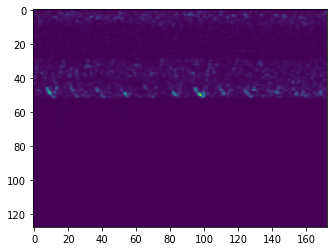

In [24]:
plt.imshow(melspectrogram(trainset[0][1].numpy(), trainset[0][2]))

In [23]:
trainset[0]

(0,
 tensor([-0.0014,  0.0107,  0.0274,  ...,  0.0314,  0.0308,  0.0305]),
 22050,
 3,
 '22601-8-0-16.wav')

In [ ]:
class_set

In [ ]:
class_dict = {}
for i, key in enumerate(class_set):
    class_dict[key] = i

In [ ]:
class_dict

In [ ]:
test_input = torch.tensor(max_data[1]).type(torch.FloatTensor)
model(test_input.unsqueeze(0).unsqueeze(0))

In [ ]:
len(max_data[1])

In [ ]:
_, _, spect = spectrogram(max_data[1])

In [ ]:
class_set = set()
for data in spect_dataset:
    class_set.add(data[0])
print(len(class_set))

In [ ]:
len_array = []
for data in spect_dataset:
    len_array.append(len(data[1]))

In [ ]:
from collections import Counter
countlist = []
counter = Counter(len_array)
for item in counter:
    countlist.append(counter[item])
countlist.sort()
print(countlist)

In [ ]:
print(counter)

In [ ]:
len(countlist)

In [ ]:
min_len = 999999999999
max_len = 0
for data in spect_dataset:
    if len(data[1]) < min_len:
        min_data = data
        min_len = len(data[1])
    if len(data[1]) > max_len:
        max_data = data
        max_len = len(data[1])

In [ ]:
max_len

In [ ]:
max_data

In [ ]:
for data in spect_dataset:
    if len(data[1]) == 96000:
        keepdata = data

In [ ]:
keepdata

In [ ]:
max_data

In [ ]:
mod_data = max_data[1][0:176400]

In [ ]:
sf.write('new_file.wav', max_data[1], max_data[2])

In [ ]:
metadata.loc[metadata['slice_file_name'] == '100032-3-0-0.wav', 'class'].item()

In [ ]:
wav = wavio.read('UrbanSound8K//audio//fold1//103074-7-0-0.wav')

In [ ]:
wav = sf.read('UrbanSound8K//audio//fold1//103074-7-0-0.wav')

In [ ]:
sf.write('new_file.wav', spect_dataset[10][1], spect_dataset[10][2])

In [ ]:
wav = wavfile.read('UrbanSound8K//audio//fold1//102842-3-1-6.wav')

In [ ]:
wav

In [ ]:
spect_dataset[10][2]